In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from prepare import prepare_data
from sklearn.base import BaseEstimator, RegressorMixin


**Loading and splitting the data**

In [206]:
df = pd.read_csv('HW3_data.csv')
raw_training_df, raw_test_df = train_test_split(df, test_size=0.2, train_size=0.8, random_state = 126)

training_df = prepare_data(raw_training_df, raw_training_df)
test_df =  prepare_data(raw_test_df, raw_training_df)

**preprocessing**

In [207]:
# X - Normalized vec with all features.
# y - vec wil contamination_level columns
X = training_df.drop(['contamination_level'], axis=1)
y = training_df['contamination_level']
# Normalized training set split into train/validation (20% of training data for validation)
X_train_temp ,X_validation, y_train_temp ,y_validation = train_test_split(X , y, test_size=0.2,random_state = 126)

**Q1**

In [208]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model
    """
    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        * Do not edit this method *

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        * Do not edit this method *

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, X, y):
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """

        # TODO: complete the loss calculation
        n_samples = X.shape[0]
        X = X.to_numpy()
        w = w.reshape(-1, 1)
        y = y.to_numpy().reshape(-1, 1)
        loss = (1.0/n_samples)*np.power(np.linalg.norm((X @ w) + b - y), 2, dtype=np.float64)
        return loss

    @staticmethod
    def gradient(w, b: float, X, y):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical gradient w.r.t w and b
        n_samples = X.shape[0]
        w_shape = w.shape
        w = w.reshape(-1,1)
        X = X.to_numpy()
        y = y.to_numpy().reshape(-1,1)
        m_1 = np.ones(n_samples).reshape(-1,1)
        g_w = (2.0/n_samples) * (X.T @ ((X @ w) + b - y))
        g_w = g_w.reshape(w_shape)
        g_b = (2.0/n_samples) * float(m_1.T @ ((X @ w) + b - y))

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val  =None, y_val = None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the gradient for the current batch
            g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y)

            # Perform a gradient step
            # TODO: update the learned parameters correctly
            assert(self.w.shape == g_w.shape)
            self.w -= self.lr*g_w
            self.b -= self.lr*g_b

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        * Do not edit this method *

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """

        # TODO: Compute
        y_pred = (X.dot(self.w.reshape(-1,1))).T + self.b

        return y_pred.T

**verify the correctness of our implementation**

In [209]:
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


**Q2**

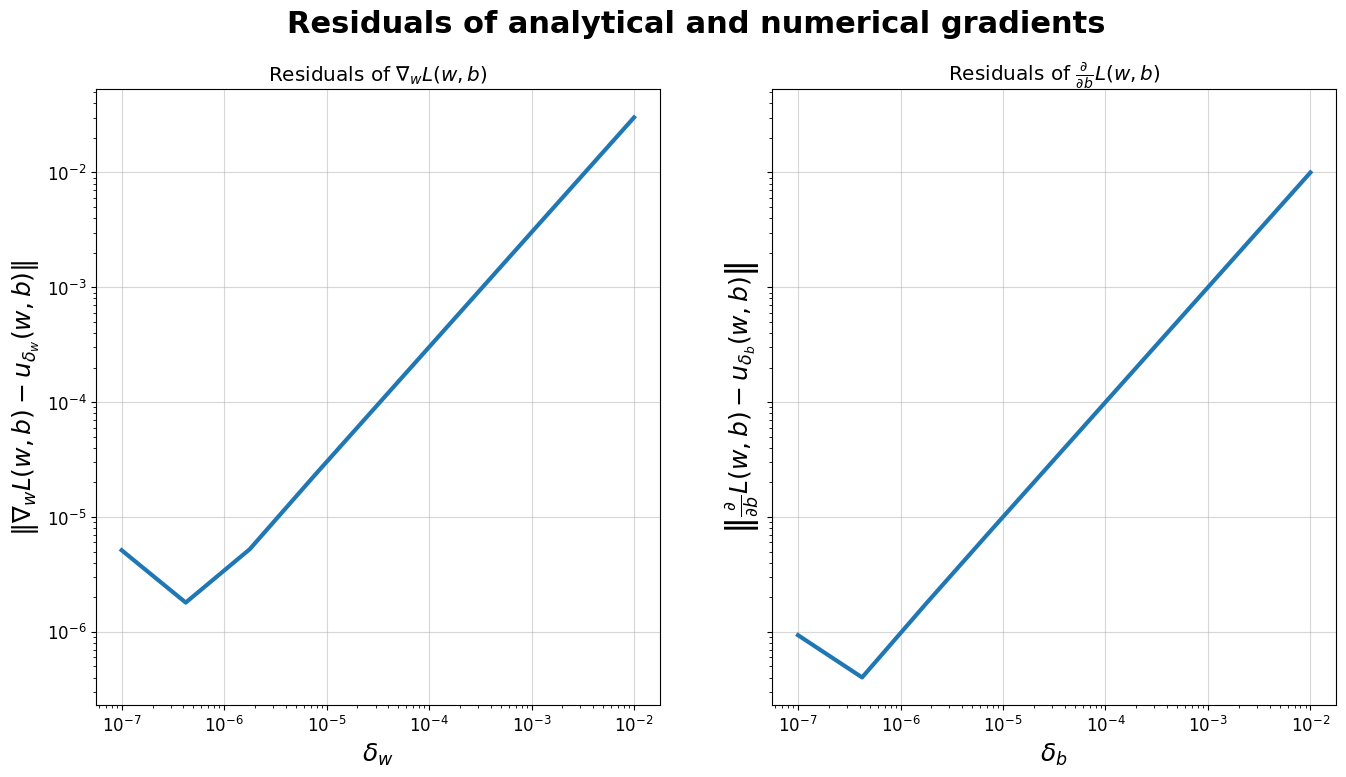

In [210]:
compare_gradients(X, y, deltas=np.logspace(-7, -2, 9))

**test_lr code**

In [211]:
import matplotlib.pyplot as plt
import numpy as np

def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)
  
  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

**Q3**

lr size = 1e-09, Best train loss = 399.63903578743106, Best validation loss = 380.2266303294227
lr size = 1e-08, Best train loss = 399.59159042443804, Best validation loss = 380.1793889035306
lr size = 1e-07, Best train loss = 399.11755139991965, Best validation loss = 379.7073895698413
lr size = 1e-06, Best train loss = 394.4183774760687, Best validation loss = 375.028643517999
lr size = 1e-05, Best train loss = 351.3145497435438, Best validation loss = 332.13123732590816
lr size = 0.0001, Best train loss = 151.59044977566666, Best validation loss = 134.1744282022552
lr size = 0.001, Best train loss = 92.97613162067027, Best validation loss = 77.41284974581458
lr size = 0.01, Best train loss = 87.80978110561468, Best validation loss = 72.37063515416415
lr size = 0.1, Best train loss = 88.30155221671738, Best validation loss = 71.45488014294568


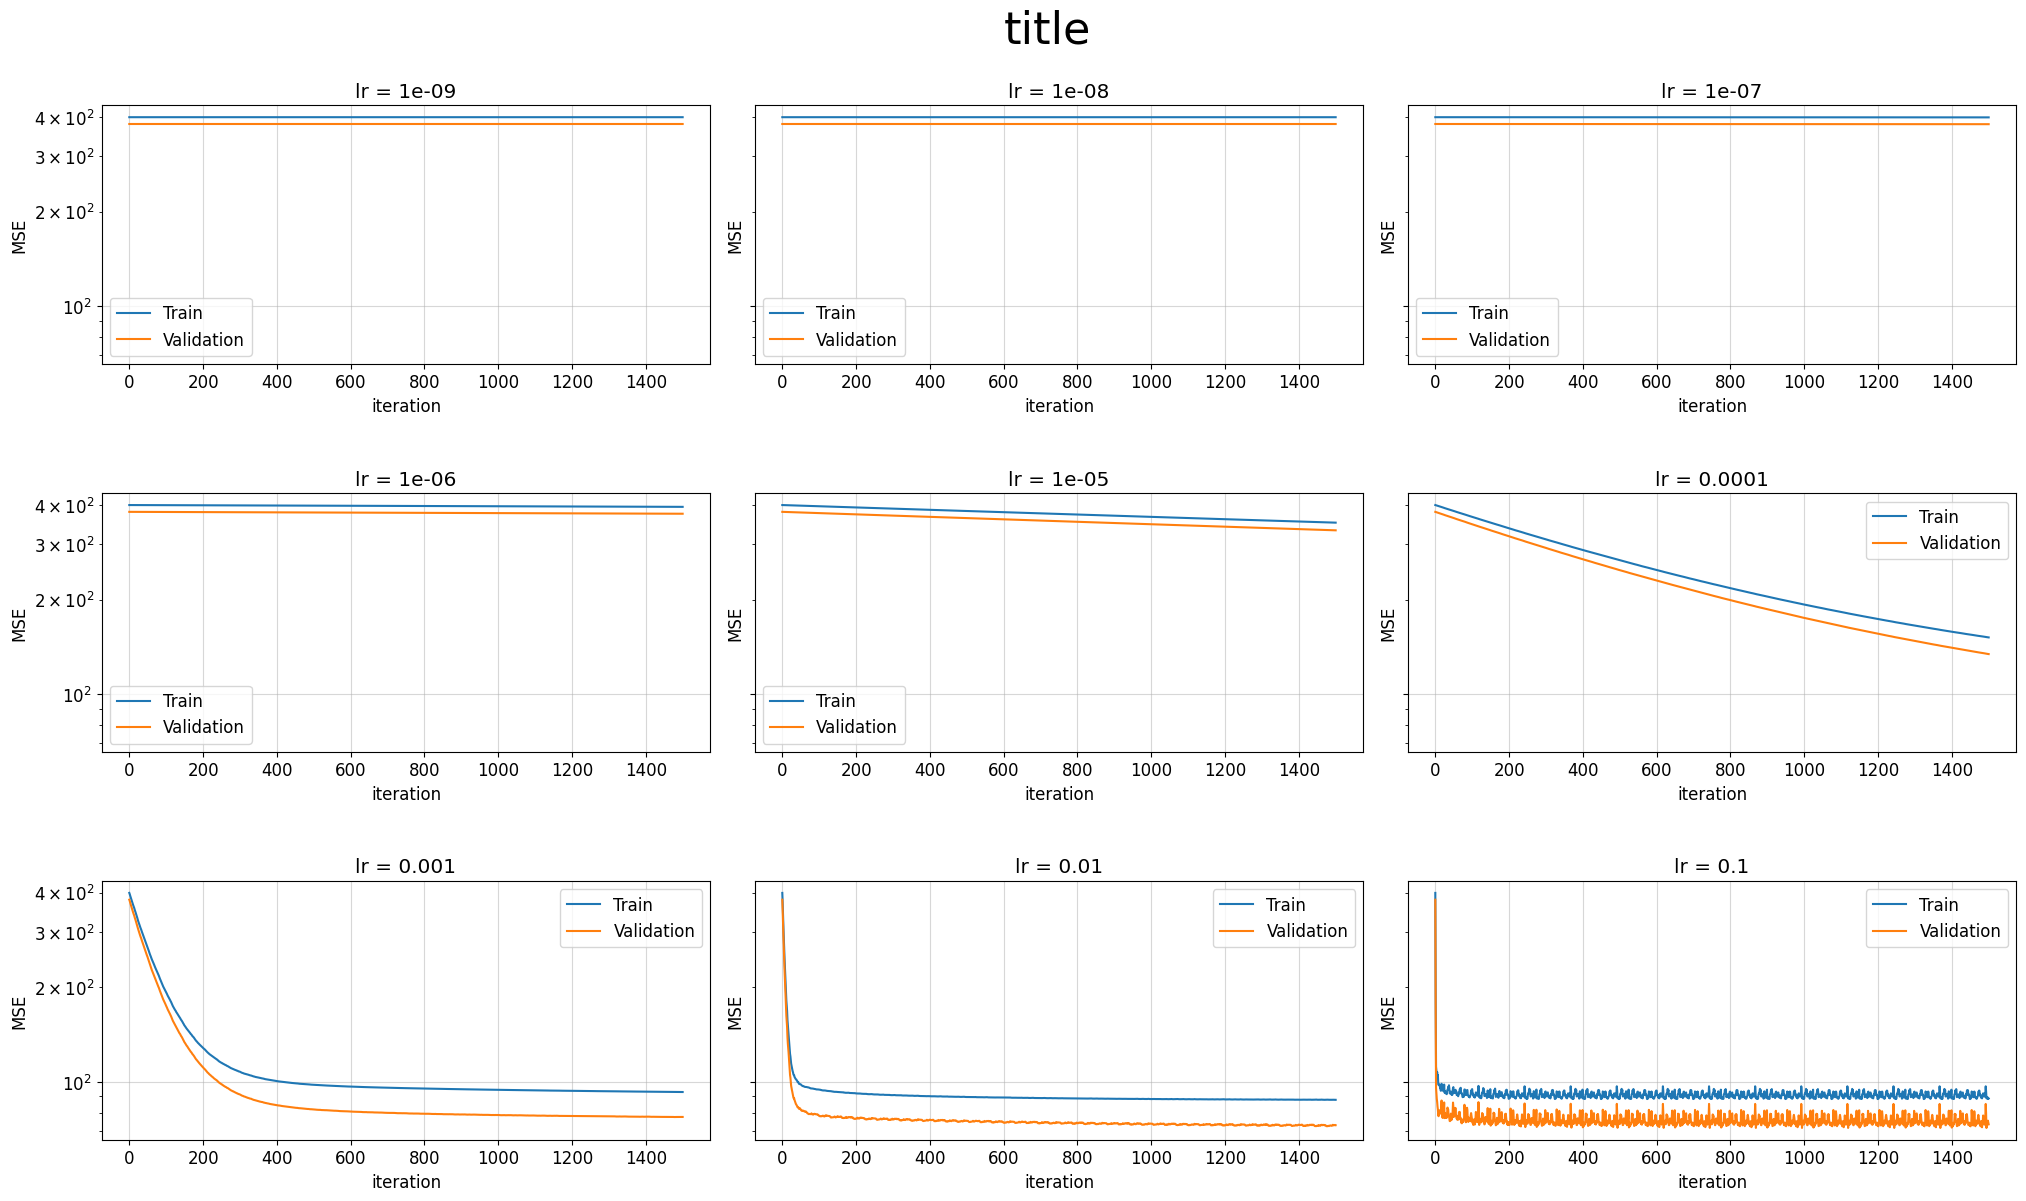

In [212]:
test_lr(X, y, X_validation, y_validation, "title")

**Section 2: Evaluation and Baseline:**


**Q4**

In [213]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate

#Creating and fitting the dummy regressor
dummy_regr = DummyRegressor(strategy="mean")
X = training_df.copy()
X = X.drop(['contamination_level'], axis=1)
y = training_df['contamination_level']
X_np = X.to_numpy()
y_np = y.to_numpy()
cv_results = cross_validate(dummy_regr, X_np, y_np, cv = 5, return_train_score = True, scoring='neg_mean_squared_error')
dummy_valid_error = np.absolute(cv_results['test_score'].mean())
dummy_training_error = np.absolute(cv_results['train_score'].mean())
print("Mean train score is "+str(dummy_training_error)+" and mean validation score is "+str(dummy_valid_error))

Mean train score is 101.29742815489915 and mean validation score is 101.62380842735993


**Retraining the dummy regressor**

In [214]:
dummy_regr.fit(X_np,y_np)

DummyRegressor()

**Q5**

The best lr value is 0.01389495494373136, its train accuracy is 87.2664476843996, and its validation accuracy is 92.9650397104659


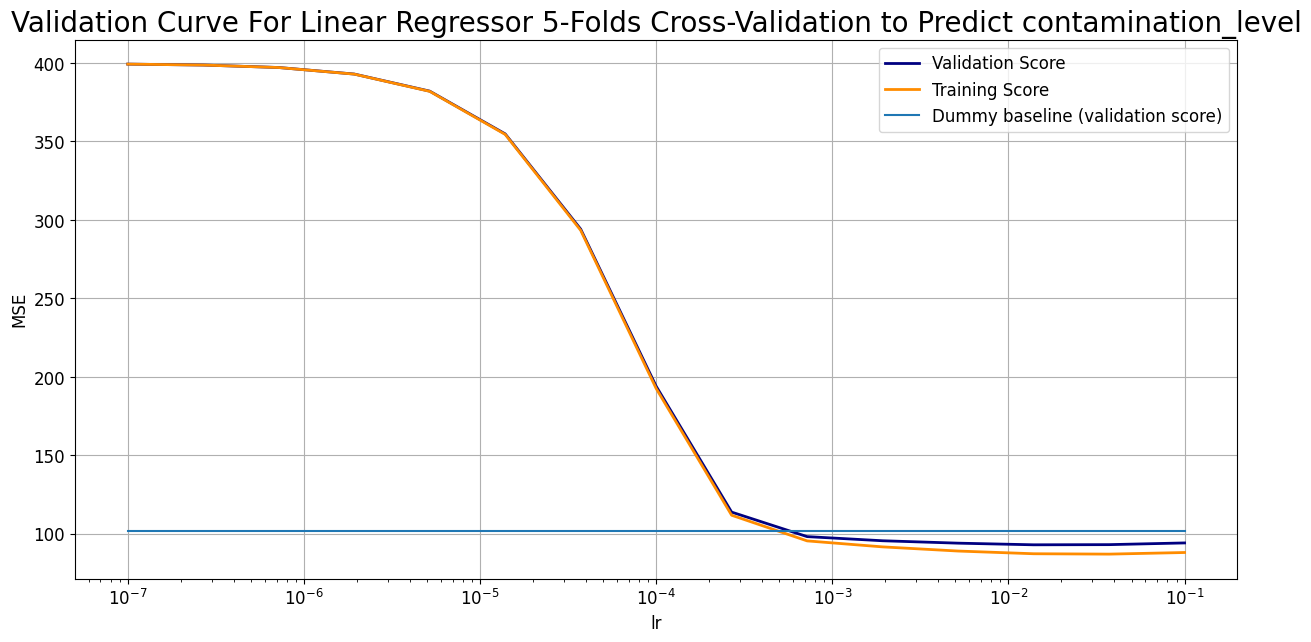

In [215]:
# Creating empty lists to store mean errors
lr_list = np.logspace(-7, -1, 15)
validation_scores_mean = []
train_scores_mean = []
dummy_error = []

X = training_df.drop(['contamination_level'], axis=1).copy()
y = training_df['contamination_level'].copy()


# Performing cross-validation with k = 5
for lr in lr_list:
    linear_regr = LinearRegressor(lr)
    cv = cross_validate(linear_regr, X , y, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    validation_scores_mean.append(np.absolute(np.mean(cv['test_score'])))
    train_scores_mean.append(np.absolute(np.mean(cv['train_score'])))
    dummy_error.append(dummy_valid_error)

# Plotting the validation curve
plt.figure(figsize=(15, 7))
plt.semilogx(lr_list, validation_scores_mean, label="Validation Score", color="navy", lw=2)
plt.semilogx(lr_list, train_scores_mean, label="Training Score", color="darkorange", lw=2)
plt.plot(lr_list, dummy_error, label='Dummy baseline (validation score)')
plt.legend()
plt.grid(visible=True)
plt.xlabel("lr")
plt.ylabel("MSE")
plt.title("Validation Curve For Linear Regressor 5-Folds Cross-Validation to Predict contamination_level", fontsize=20)

best_validation_accuracy = np.min(validation_scores_mean)
best_validation_accuracy_index = validation_scores_mean.index(best_validation_accuracy)
train_accuracy = train_scores_mean[best_validation_accuracy_index]
best_lr = lr_list[best_validation_accuracy_index]
print("The best lr value is " + str(best_lr) + ", its train accuracy is " + str(train_accuracy) +
      ", and its validation accuracy is " + str(best_validation_accuracy))


In [216]:
X = training_df.drop(['contamination_level'], axis=1).copy()
y = training_df['contamination_level'].copy()

linear_regressor = LinearRegressor(best_lr)
linear_regressor.fit(X,y)

LinearRegressor(lr=0.01389495494373136)

**Section 3: Ridge linear regression**

**Q7**

best alpha value is 100.0 , its train accuracy is 87.50430950134839and its validation accuracy is 91.70350241992742


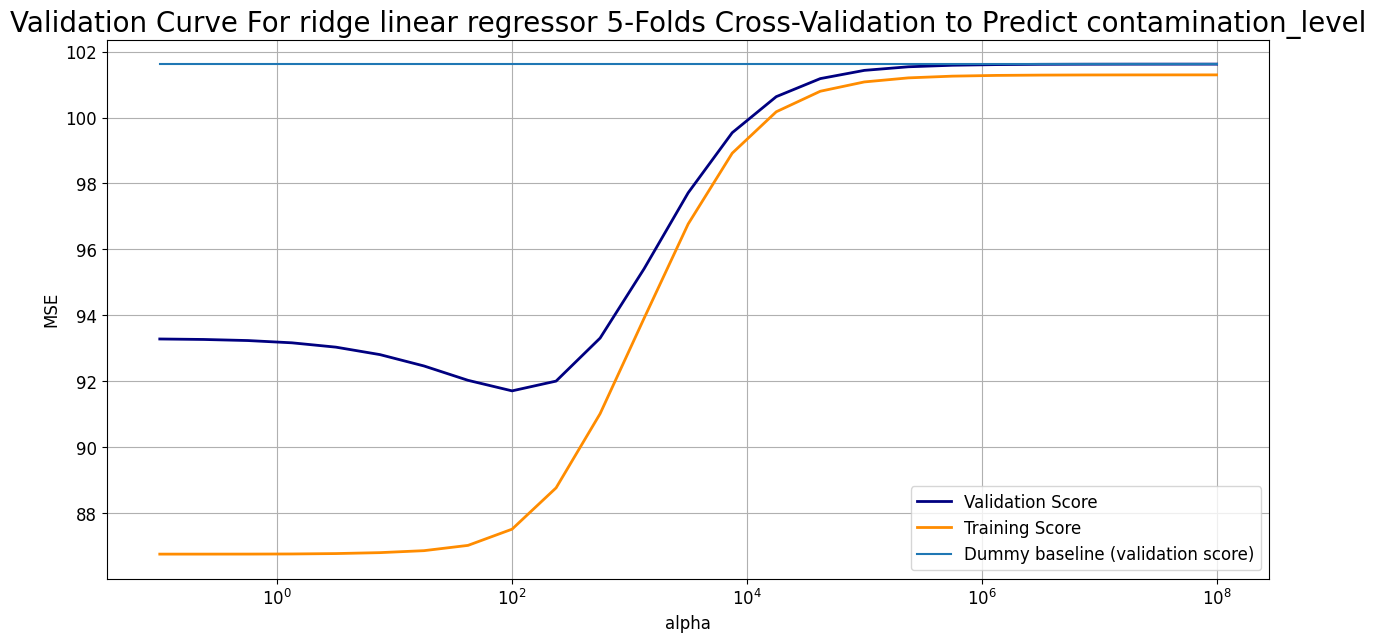

In [217]:
from sklearn.linear_model import Ridge

#Creating dataframes and empty lists to store mean errors
alpha_list = np.logspace(-1, 8, 25)
validation_scores_mean = []
train_scores_mean = []
dummy_error = []

X = training_df.drop(['contamination_level'], axis=1).copy()
y = training_df['contamination_level'].copy()


#Performing cross validation with k = 5
for alpha in alpha_list:
  ridge_inst = Ridge(alpha, fit_intercept=True)
  cv = cross_validate(ridge_inst, X_np, y_np, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
  validation_scores_mean.append(np.absolute(np.mean(cv['test_score'])))
  train_scores_mean.append(np.absolute(np.mean(cv['train_score'])))
  dummy_error.append(dummy_valid_error)

#Plotting the validation curve
plt.figure(figsize=(15, 7))
plt.semilogx(alpha_list, validation_scores_mean, label="Validation Score", color="navy", lw=2)
plt.semilogx(alpha_list, train_scores_mean, label="Training Score", color="darkorange", lw=2)
plt.plot(alpha_list, dummy_error, label='Dummy baseline (validation score)')
plt.legend()
plt.grid(visible = True)
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.title("Validation Curve For ridge linear regressor 5-Folds Cross-Validation to Predict contamination_level", fontsize = 20)

best_validation_accuracy = np.min(validation_scores_mean)
best_validation_accuracy_index = validation_scores_mean.index(best_validation_accuracy)
train_accuracy = train_scores_mean[best_validation_accuracy_index]
best_alpha = alpha_list[best_validation_accuracy_index]
print("best alpha value is "+str(best_alpha)+" , its train accuracy is "+str(train_accuracy)+ \
      "and its validation accuracy is "+str(best_validation_accuracy))


**Q8**

In [218]:
X = training_df.drop(['contamination_level'], axis=1).copy()
y = training_df['contamination_level'].copy()
ridge_linear_regressor = Ridge(best_alpha, fit_intercept=True)
ridge_linear_regressor.fit(X,y)

Ridge(alpha=100.0)

**Q9**

In [219]:
# Assuming 'ridge_linear_regressor' is the trained Ridge regressor

# Get the absolute coefficients and corresponding feature names
coefficients = np.abs(ridge_linear_regressor.coef_)
feature_names = X.columns

# Find the indices of the top five features with the largest absolute coefficients
top_feature_indices = np.argsort(coefficients)[-5:]

# Get the top five features and their corresponding coefficients
top_features = feature_names[top_feature_indices]
top_coefficients = coefficients[top_feature_indices]

# Print the top five features and coefficients
for feature, coefficient in zip(top_features[::-1], top_coefficients[::-1]):
    print("Feature: {}, Coefficient: {:.4f}".format(feature, coefficient))


Feature: PCR_01, Coefficient: 2.8183
Feature: sugar_levels, Coefficient: 2.2678
Feature: sport_activity, Coefficient: 0.6751
Feature: shortness_of_breath, Coefficient: 0.6744
Feature: cough, Coefficient: 0.6159


**Q10**

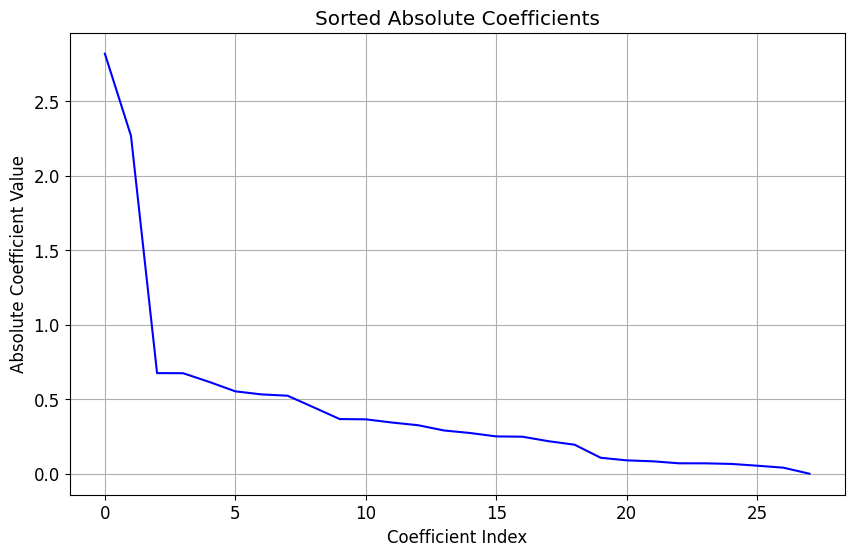

In [220]:
import matplotlib.pyplot as plt

# Sort the absolute coefficients and obtain the corresponding indices
sorted_indices = np.argsort(np.abs(ridge_linear_regressor.coef_))[::-1]

# Sort the absolute coefficients in descending order
sorted_coefficients = np.abs(ridge_linear_regressor.coef_)[sorted_indices]

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_coefficients)), sorted_coefficients,  linestyle='-', color='b')
plt.xlabel('Coefficient Index')
plt.ylabel('Absolute Coefficient Value')
plt.title('Sorted Absolute Coefficients')
plt.grid(True)
plt.show()


**Section 4: Polynomial fitting (visualization)**

In [221]:
subset_df = training_df[['PCR_01', 'PCR_05', 'contamination_level']].copy()


In [222]:
def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1, 
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    ax.view_init(elev=5., azim=45*i)
  
  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

**Q14**

C:\Users\Yehonatan Nahamias\AppData\Local\Temp\ipykernel_3032\3733405945.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


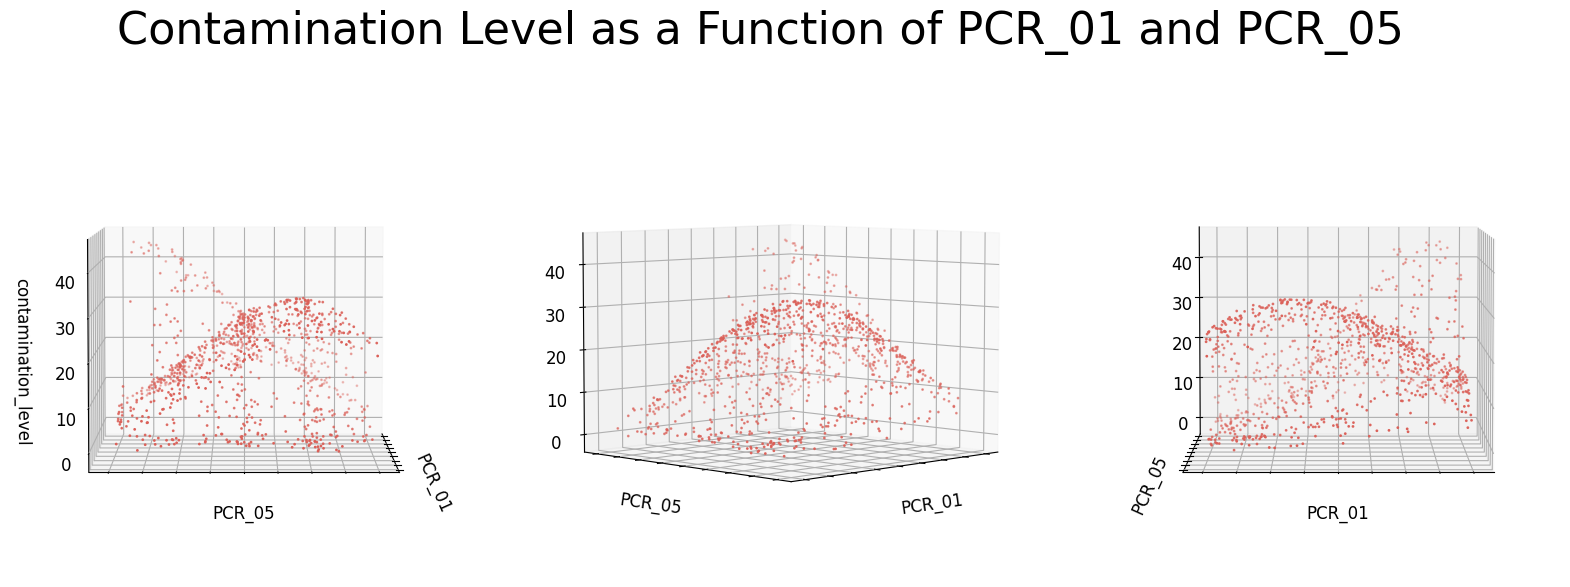

In [223]:

# Call the plot3d function to visualize the data
plot3d(subset_df, 'PCR_01', 'PCR_05', 'contamination_level', 'Contamination Level as a Function of PCR_01 and PCR_05')

**Q15**

The best alpha value is 42.16965, its train accuracy is 96.35009, and its validation accuracy is 97.40968


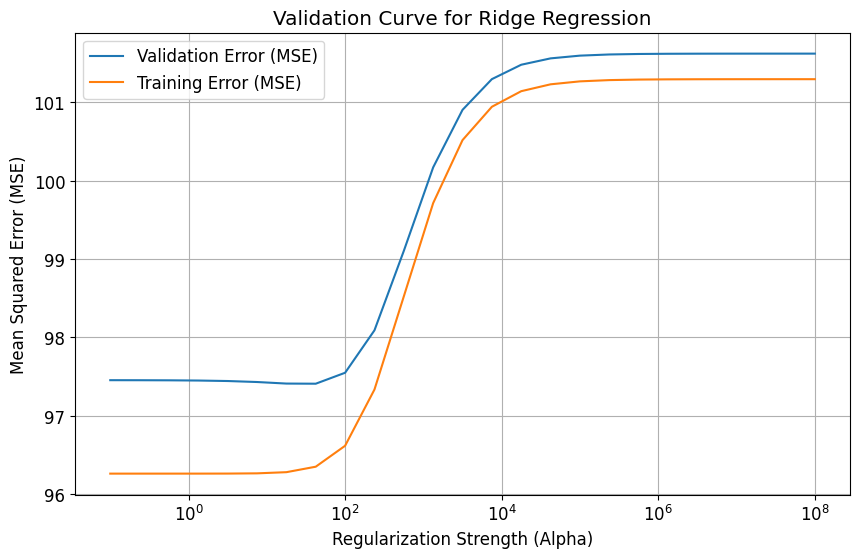

In [224]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

# Create a subset DataFrame with the two features and the target variable
subset_df = training_df[['PCR_01', 'PCR_05', 'contamination_level']].copy()

# Split the data into X (features) and y (target variable)
X = subset_df[['PCR_01', 'PCR_05']].copy()
y = subset_df['contamination_level'].copy()

# Define the range of regularization strengths to test
alpha_range = np.logspace(-1, 8, 25)

# Create empty lists to store mean validation errors and best alpha values
validation_errors = []
training_errors = []
best_alpha = None
best_validation_error = float('inf')

# Perform cross-validation with different regularization strengths
for alpha in alpha_range:
    ridge_regressor = Ridge(alpha=alpha, fit_intercept=True)
    cv_results = cross_validate(ridge_regressor, X, y, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    mean_val_error = -np.mean(cv_results['test_score'])
    mean_train_error = -np.mean(cv_results['train_score'])
    validation_errors.append(mean_val_error)
    training_errors.append(mean_train_error)
    
    if mean_val_error < best_validation_error:
        best_validation_error = mean_val_error
        best_alpha = alpha

# Plot the validation curve with training curve
plt.figure(figsize=(10, 6))
plt.semilogx(alpha_range, validation_errors, label="Validation Error (MSE)")
plt.semilogx(alpha_range, training_errors, label="Training Error (MSE)")
plt.xlabel('Regularization Strength (Alpha)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Validation Curve for Ridge Regression')
plt.grid(True)
plt.legend()

# Find the index of the best alpha
best_alpha_index = np.argmin(validation_errors)

# Print the results
best_alpha_value = alpha_range[best_alpha_index]
train_accuracy = training_errors[best_alpha_index]
validation_accuracy = validation_errors[best_alpha_index]
print(f"The best alpha value is {best_alpha_value:.5f}, its train accuracy is {train_accuracy:.5f}, and its validation accuracy is {validation_accuracy:.5f}")

plt.show()


In [225]:
ridge_linear_regressor = Ridge(best_alpha_value, fit_intercept=True)
ridge_linear_regressor.fit(X,y)

Ridge(alpha=42.169650342858226)

**Q16**

C:\Users\Yehonatan Nahamias\AppData\Local\Temp\ipykernel_3032\3733405945.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


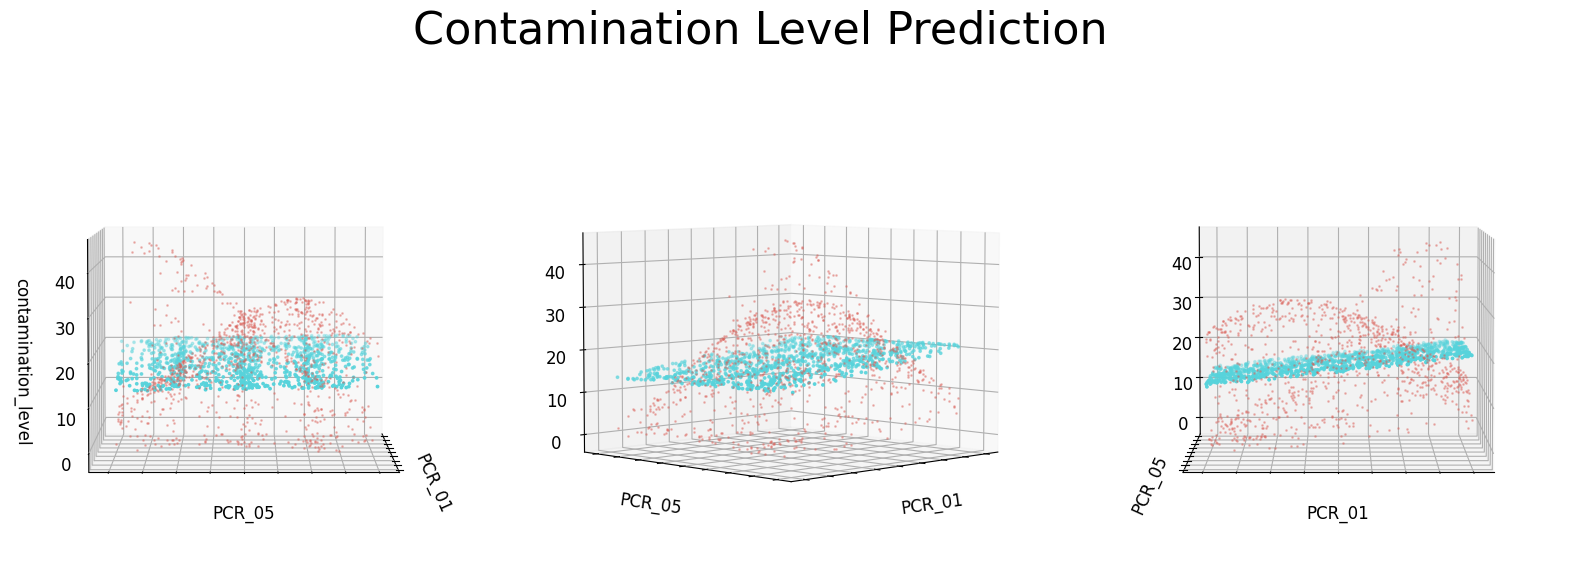

In [226]:

# Get the predicted values from the trained Ridge regressor
y_pred = ridge_linear_regressor.predict(X)

# Plot the data using plot3d
plot3d(subset_df, 'PCR_01', 'PCR_05', 'contamination_level', 'Contamination Level Prediction',
       predictions=y_pred)




**Q17**

In [227]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import Ridge

# Create the pipeline
poly_reg = Pipeline([
    ('feature_mapping', PolynomialFeatures(degree=3)),
    ('normalization', MinMaxScaler()),
    ('Ridge', Ridge(alpha=best_alpha_value, fit_intercept=True))
])


**Q18**

The best regularization strength is 0.8254, its train accuracy is 77.6272, and its validation accuracy is 79.5959


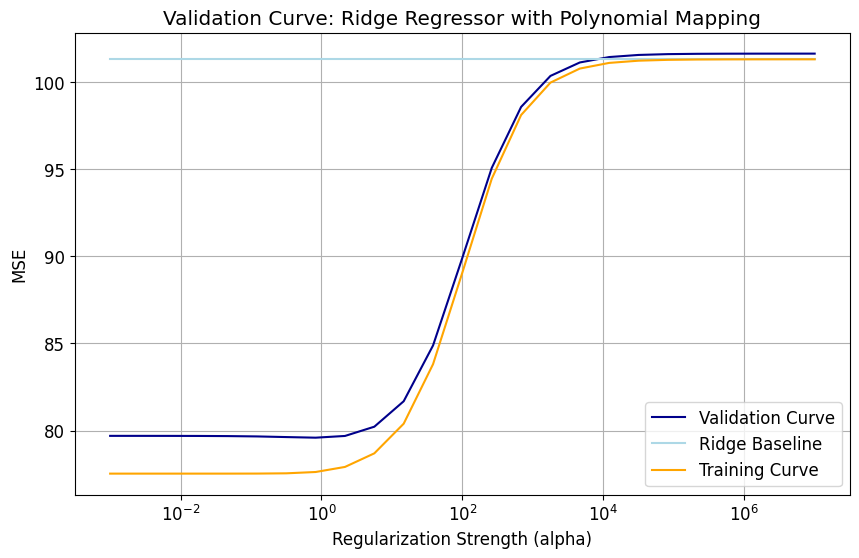

In [228]:
from sklearn.model_selection import cross_validate
import numpy as np
import matplotlib.pyplot as plt

X = subset_df[['PCR_01', 'PCR_05']].copy()
y = subset_df['contamination_level'].copy()
# Define the range of regularization strengths to test
alpha_range = np.logspace(-3, 7, 25)

# Perform cross-validation with different regularization strengths
validation_scores_mean = []
train_scores_mean = []
ridge_baseline_error = []
for alpha in alpha_range:
    poly_reg.set_params(Ridge__alpha=alpha)  # Set the alpha parameter in the Ridge regressor
    cv_results = cross_validate(poly_reg, X, y, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    validation_scores_mean.append(np.mean(np.abs(cv_results['test_score'])))
    train_scores_mean.append(np.mean(np.abs(cv_results['train_score'])))
    ridge_baseline_error.append(np.mean(np.square(y - np.mean(y))))  # Ridge baseline error

# Plot the validation curve, ridge baseline, and training curve
plt.figure(figsize=(10, 6))
plt.semilogx(alpha_range, validation_scores_mean, label="Validation Curve", color="darkblue")
plt.semilogx(alpha_range, ridge_baseline_error, label="Ridge Baseline", color="lightblue")
plt.semilogx(alpha_range, train_scores_mean, label="Training Curve", color="orange")
plt.xlabel('Regularization Strength (alpha)')
plt.ylabel('MSE')
plt.title('Validation Curve: Ridge Regressor with Polynomial Mapping')
plt.grid(True)
plt.legend()

# Find the best regularization strength with the lowest validation error
best_alpha = alpha_range[np.argmin(validation_scores_mean)]
best_validation_error = np.min(validation_scores_mean)
best_train_accuracy = train_scores_mean[np.argmin(validation_scores_mean)]
print(f"The best regularization strength is {best_alpha:.4f}, its train accuracy is {best_train_accuracy:.4f}, "
      f"and its validation accuracy is {best_validation_error:.4f}")

plt.show()


In [229]:
poly_reg_contamination_level = Pipeline([
    ('feature_mapping', PolynomialFeatures(degree=3)),
    ('normalization', MinMaxScaler()),
    ('Ridge', Ridge(alpha=best_alpha_value, fit_intercept=True))
])
poly_reg_contamination_level.fit(X,y)

Pipeline(steps=[('feature_mapping', PolynomialFeatures(degree=3)),
                ('normalization', MinMaxScaler()),
                ('Ridge', Ridge(alpha=42.169650342858226))])

C:\Users\Yehonatan Nahamias\AppData\Local\Temp\ipykernel_3032\3733405945.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


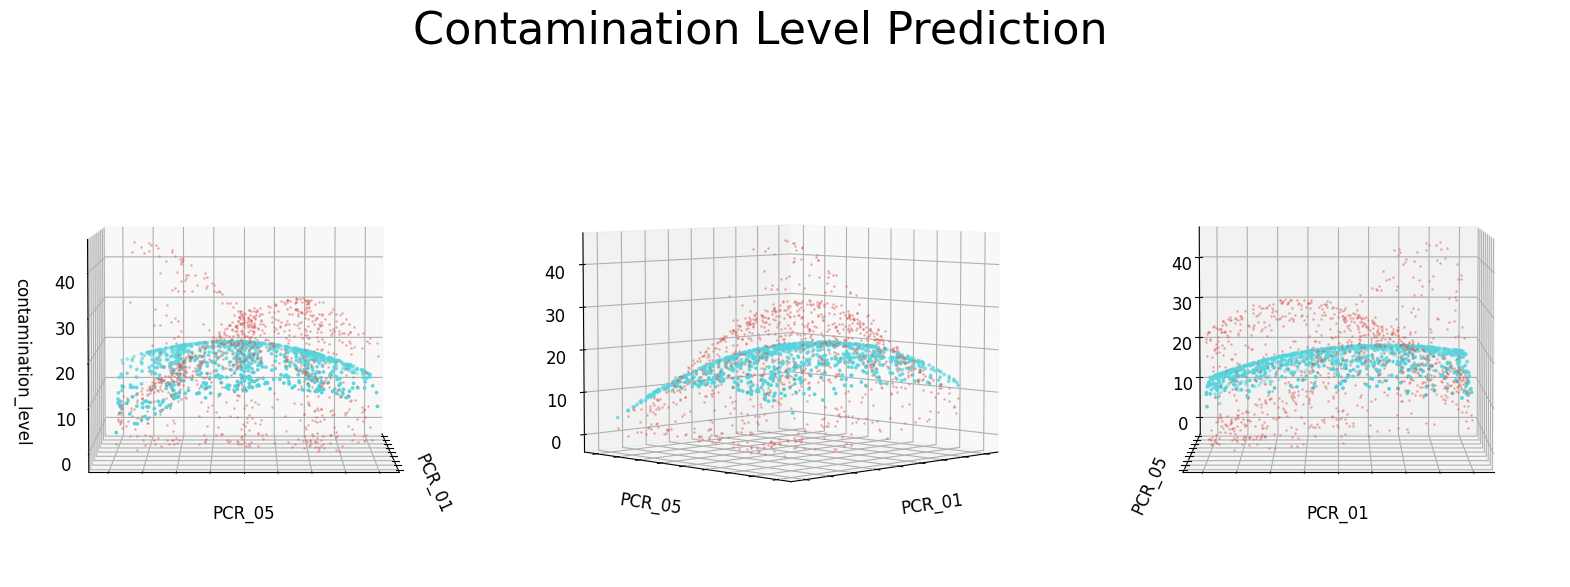

In [230]:
# Get the predicted values from the trained Ridge regressor
y_pred = poly_reg_contamination_level.predict(X)

# Plot the data using plot3d
plot3d(subset_df, 'PCR_01', 'PCR_05', 'contamination_level', 'Contamination Level Prediction',
       predictions=y_pred)

**Section 5: Fitting Gradient Boosted Machines (GBM)**

In [231]:
from sklearn.ensemble import GradientBoostingRegressor

# Create copies of the train and test sets
X_train_gbm = training_df.copy()
X_test_gbm = test_df.copy()
y_train=training_df['contamination_level'].copy()

# Select the relevant features
features = ['PCR_01', 'PCR_02', 'PCR_03', 'PCR_04', 'PCR_05', 'PCR_09', 'PCR_10', 'sugar_levels', 'sport_activity']

# Create the GBM regressor
gbm_regressor = GradientBoostingRegressor()


In [232]:
# Create the pipeline
gbm_pipeline = Pipeline([
    ('feature_mapping', PolynomialFeatures(degree=3)),
    ('normalization', MinMaxScaler()),
    ('gbm', GradientBoostingRegressor())
])


In [233]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the parameter grid for grid search
param_grid = {
    'loss': ['absolute_error', 'quantile', 'squared_error', 'huber'],
    'learning_rate': np.logspace(-3, 0, 4),
    'subsample': np.linspace(0.5, 1.0, 6),
    'min_samples_leaf': [1, 3, 5, 7]
}

In [234]:

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=gbm_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train_gbm[features], y_train)



GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': array([0.001, 0.01 , 0.1  , 1.   ]),
                         'loss': ['absolute_error', 'quantile', 'squared_error',
                                  'huber'],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             return_train_score=True, scoring='neg_mean_squared_error')

In [235]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the mean train and validation scores for each parameter combination
mean_train_scores = grid_search.cv_results_["mean_train_score"]
mean_val_scores = grid_search.cv_results_["mean_test_score"]

# Reshape the scores to match the parameter grid dimensions
mean_train_scores = np.array(mean_train_scores).reshape(
    len(param_grid['loss']),
    len(param_grid['learning_rate']),
    len(param_grid['subsample']),
    len(param_grid['min_samples_leaf'])
)
mean_val_scores = np.array(mean_val_scores).reshape(
    len(param_grid['loss']),
    len(param_grid['learning_rate']),
    len(param_grid['subsample']),
    len(param_grid['min_samples_leaf'])
)

# Get the best parameters and scores
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and score
print("Best Parameters:", best_params)
print("Best Score:", best_score)
train_mse = mean_train_scores.mean()
val_mse = mean_val_scores.mean()





Best Parameters: {'learning_rate': 0.1, 'loss': 'huber', 'min_samples_leaf': 5, 'subsample': 0.6}
Best Score: -3.3763145671286283


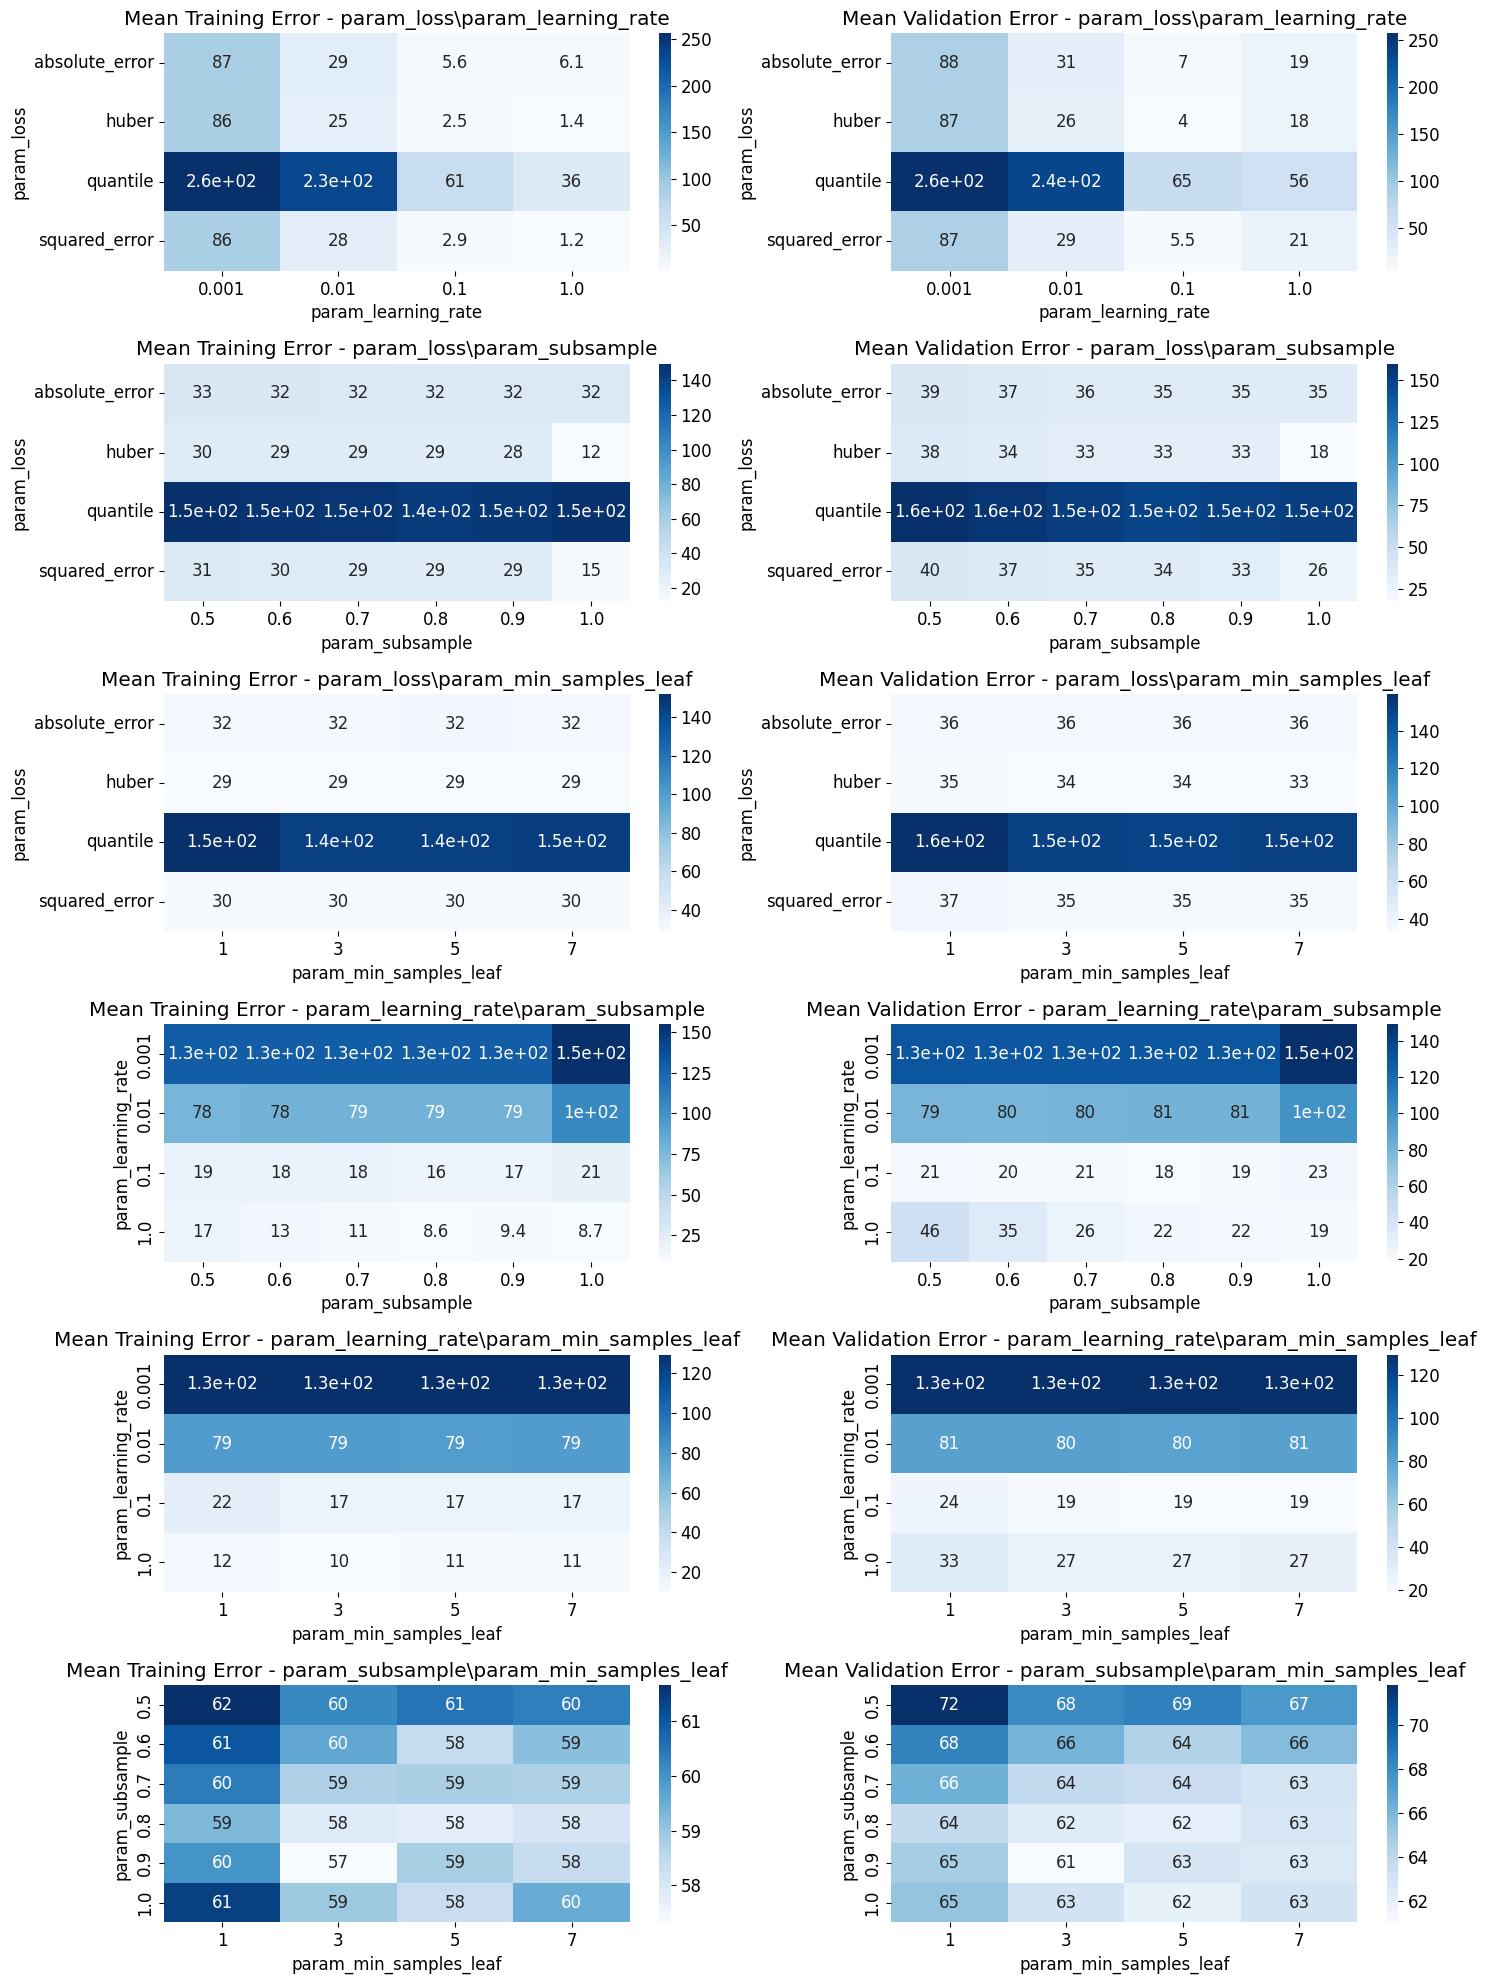

In [237]:
# Create a list of parameter pairs
param_pairs = [('param_loss', 'param_learning_rate'),
               ('param_loss', 'param_subsample'),
               ('param_loss', 'param_min_samples_leaf'),
               ('param_learning_rate', 'param_subsample'),
               ('param_learning_rate', 'param_min_samples_leaf'),
               ('param_subsample', 'param_min_samples_leaf')]

new_param_pairs=[('param_subsample', 'param_min_samples_leaf'),
                ('param_learning_rate', 'param_subsample'),
                ('param_learning_rate', 'param_subsample'),
                ('param_loss', 'param_min_samples_leaf'),
                ('param_loss', 'param_subsample'),
                ('param_loss', 'param_learning_rate')]


# Plot the heatmaps for each parameter pair
plt.rcParams.update({'font.size': 12})
plt.rcParams["figure.figsize"] = [15, 20]
fig, axes = plt.subplots(6, 2)

for i, pair in enumerate(param_pairs):
    x_param, y_param = pair

    # Filter dataframe based on parameter pair
    pair_train_df = cv_train_res[[x_param, y_param, 'mean_train_score']]
    pair_test_df = cv_test_res[[x_param, y_param, 'mean_test_score']]

    # Drop duplicate rows
    pair_train_df = pair_train_df.drop_duplicates()
    pair_test_df = pair_test_df.drop_duplicates()

    # Convert parameter columns to string
    pair_train_df[x_param] = pair_train_df[x_param].astype(str)
    pair_train_df[y_param] = pair_train_df[y_param].astype(str)
    pair_test_df[x_param] = pair_test_df[x_param].astype(str)
    pair_test_df[y_param] = pair_test_df[y_param].astype(str)

    # Perform groupby operation
    pair_train_df = pair_train_df.groupby([x_param, y_param]).mean().reset_index()
    pair_test_df = pair_test_df.groupby([x_param, y_param]).mean().reset_index()

    # Pivot the dataframes
    pair_train_df = pair_train_df.pivot(index=x_param, columns=y_param, values='mean_train_score')
    pair_test_df = pair_test_df.pivot(index=x_param, columns=y_param, values='mean_test_score')

    # Plot the heatmaps
    sns.heatmap(pair_train_df, ax=axes[i, 0], annot=True, cmap="Blues").set(title='Mean Training Error - {}\{}'.format(x_param, y_param))
    sns.heatmap(pair_test_df, ax=axes[i, 1], annot=True, cmap="Blues").set(title='Mean Validation Error - {}\{}'.format(x_param, y_param))

# Adjust the layout and show the heatmaps
plt.tight_layout()
plt.show()


**Section 6: Testing your models**


In [238]:
#Creating dataframes
test_features = test_df.drop(columns = ['contamination_level']).to_numpy()
test_label = test_df.contamination_level.to_numpy()
train_features = training_df.drop(columns = ['contamination_level']).to_numpy()
train_label = training_df.contamination_level.to_numpy()

In [239]:
from sklearn.metrics import mean_squared_error
#Dummy regressor

print("Accuracy score for dummy regressor is "+str(dummy_regr.score(test_features, test_label)))
print("MSE for dummy regressor is "+str(mean_squared_error(dummy_regr.predict(test_features), test_label)))

Accuracy score for dummy regressor is 0.0
MSE for dummy regressor is 101.33006618214523


In [240]:
#Linear regressor
print("Accuracy score for linear regressor is "+str(linear_regressor.score(test_features, test_label)))
print("MSE for linear regressor is "+str(mean_squared_error(linear_regressor.predict(test_features), test_label)))

Accuracy score for linear regressor is 0.1311981449566828
MSE for linear regressor is 88.03574947070989


In [241]:
#Ridge linear regressor
X = training_df.drop(['contamination_level'], axis=1).copy()
y = training_df['contamination_level'].copy()
ridge_linear_regressor = Ridge(best_alpha, fit_intercept=True)
ridge_linear_regressor.fit(X,y)
print("Accuracy score for ridge linear regressor is "+str(ridge_linear_regressor.score(test_features, test_label)))
print("MSE for ridge linear regressor is "+str(mean_squared_error(ridge_linear_regressor.predict(test_features), test_label)))

Accuracy score for ridge linear regressor is 0.13521119060386833
MSE for ridge linear regressor is 87.6291072896886


c:\Users\Yehonatan Nahamias\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
c:\Users\Yehonatan Nahamias\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


In [242]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# GBM 
best_params = grid_search.best_params_
gbm_model = GradientBoostingRegressor(**best_params)

# Fit the model with the training data
gbm_model.fit(X, y)

# Compute the mean validation error using cross-validation
val_scores = cross_val_score(gbm_model, X, y, cv=5, scoring='neg_mean_squared_error')
mean_val_error = -val_scores.mean()

# Compute the mean training error
train_predictions = gbm_model.predict(X)
mean_train_error = mean_squared_error(y, train_predictions)

print("Mean Training Error:", mean_train_error)
print("Mean Validation Error:", mean_val_error)

# Make predictions on the test data
test_predictions = gbm_model.predict(test_features)

# Calculate accuracy score and MSE on the test data
accuracy_score = gbm_model.score(test_features, test_label)
mse = mean_squared_error(test_predictions, test_label)

print("Accuracy score for GBM is", accuracy_score)
print("MSE for GBM is", mse)


Mean Training Error: 2.536155594436316
Mean Validation Error: 4.955351129808594
Accuracy score for GBM is 0.8552652932483802
MSE for GBM is 14.665977413995021


c:\Users\Yehonatan Nahamias\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\Yehonatan Nahamias\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
